## Introduction

For identifiying the defects by segmentation a CNN architecture (ResUNet) proposed [ResUNet-a: a deep learning framework for semantic segmentation of remotely sensed data](https://arxiv.org/abs/1904.00592) will be applied.
<br>
The notebook is based on [this](https://www.kaggle.com/ekhtiar/resunet-a-baseline-on-tensorflow) notebook on kaggle but the model is adjusted to be in line with the ResUNet architecture described in the paper.


#### Imports

In [4]:
# some basic imports
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [5]:
# imports for building the network
import tensorflow as tf
from tensorflow import reduce_sum
from tensorflow.keras.backend import pow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Add, Flatten
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

#### Configurations

In [6]:
# Kernel Configurations

load_model = True # load a pretrained model
train_dir = 'data/' # directory of training images
model_path = 'model_final.h5' # path of pretrained model
train_image_dir = os.path.join(train_dir, 'train_images') # 

In [7]:
# config. parameters
# faster computation we resize the image from the original size (1600x256)
img_w = 256 # resized weidth
img_h = 256 # resized height
batch_size = 12
epochs = 25
# batch size for training unet
k_size = 3 # kernel size 3x3
val_size = .20 # split of training set between train and validation set
# we will repeat the images with lower samples to make the training process more fair

#### Load & Transform train.csv

In [8]:
# load full data and label no mask as -1
train_df = pd.read_csv(os.path.join(train_dir, 'train.csv')).fillna(-1)

In [9]:
# ImageID: path to image of steel sample
# ClassId: type of error appearing in an image (in [1,2,3,4])
#          if multiple errors appear in one image than this image is listed multiple times (one time per error type that appears)
# EncodedPixles: run length encoded mask pixles
#                this encoding describes in a memory efficient way the positions of the marked pixles of a mask
#                which is flattend to 1D
#                e.g. the sequence 29102 12 29346 24... means that starting from pixle 291012 the next 12 pixles are equal to 1
#                and correspondingly starting form pixle 29346 the next 24 pixles are equal to 1 and so on
train_df.head()

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

In [10]:
# lets create a dict with class id and encoded pixels and group all the defaults per image
train_df['ClassId_EncodedPixels'] = train_df.apply(lambda row: (row['ClassId'], row['EncodedPixels']), axis = 1)
grouped_EncodedPixels = train_df.groupby('ImageId')['ClassId_EncodedPixels'].apply(list)

In [11]:
# for each image the mask pixle coordinates (RLE) for all error types are provided as list of tuples
grouped_EncodedPixels.head(3)

ImageId
0002cc93b.jpg    [(1, 29102 12 29346 24 29602 24 29858 24 30114...
0007a71bf.jpg    [(3, 18661 28 18863 82 19091 110 19347 110 196...
000a4bcdd.jpg    [(1, 37607 3 37858 8 38108 14 38359 20 38610 2...
Name: ClassId_EncodedPixels, dtype: object

In [12]:
train_df['ImageId_ClassId'] = train_df.apply(lambda x: x['ImageId']+'_'+str(x['ClassId']),1)

#### Utility Functions for RLE Encoding & Decoding

In [13]:
# from https://www.kaggle.com/robertkag/rle-to-mask-converter
def rle_to_mask(rle_string,height,width):
    '''
    convert RLE(run length encoding) string to numpy array

    Parameters: 
    rleString (str): Description of arg1 
    height (int): height of the mask
    width (int): width of the mask 

    Returns: 
    numpy.array: numpy array of the mask
    '''
    rows, cols = height, width
    if rle_string == -1:
        return np.zeros((height, width))
    else:
        rleNumbers = [int(numstring) for numstring in rle_string.split()]
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        img = np.zeros(rows*cols,dtype=np.uint8)
        for index,length in rlePairs:
            index -= 1
            img[index:index+length] = 255
        img = img.reshape(cols,rows)
        img = img.T
        return img

In [14]:
def mask_to_rle(mask):
    '''
    Convert a mask into RLE
    
    Parameters: 
    mask (numpy.array): binary mask of numpy array where 1 - mask, 0 - background

    Returns: 
    string: run length encoding 
    '''
    pixels= mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Data Generator

The following generator allows us to load data progressively, so that having all images/data in memory at the same time is not necessary. Moreover, custom preprocessing or augementation methods can be included in the loading process of the generator.

In [23]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_ids, labels, image_dir, batch_size=32,
                 img_h=256, img_w=512, shuffle=True, test=False):
        
        self.list_ids = list_ids
        self.labels = labels
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.test = test
        self.on_epoch_end()
    
    def __len__(self):
        'denotes the number of batches per epoch'
        return int(np.floor(len(self.list_ids) / self.batch_size))
    
    def __getitem__(self, index):
        'generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # get list of IDs
        list_ids_temp = [self.list_ids[k] for k in indexes]
        # generate data
        X, y = self.__data_generation(list_ids_temp)
        # return data 
        return X, y
    
    def on_epoch_end(self):
        'update ended after each epoch'
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def random_flip(self,x,m):
        if np.random.randint(2):
            x = x[:,::-1]
            m = m[:,::-1,:]
        if np.random.randint(2):
            x = x[::-1,:]
            m = m[::-1,:,:]  
        return x,m
            
    def random_mix(self,x,m):
        if np.random.randint(2):
            x_0 = np.zeros(x.shape,dtype='float32')
            m_0 = np.zeros(m.shape,dtype='float32')
            ind = np.random.randint(1,x.shape[1]-1)
            x_0[:,:ind] = x[:,-ind:]
            m_0[:,:ind,:] = m[:,-ind:,:]
            x_0[:,ind:] = x[:,:-ind]
            m_0[:,ind:,:] = m[:,:-ind,:]
            if np.random.randint(2):
                ind = np.random.randint(1,x.shape[0]-1)
                x_0[:ind,:] = x[-ind:,:]
                m_0[:ind,:,:] = m[-ind:,:,:]
                x_0[ind:,:] = x[:-ind,:]
                m_0[ind:,:,:] = m[:-ind,:,:] 
            return x_0,m_0
        return x,m
            
    def __data_generation(self, list_ids_temp):
        'generate data containing batch_size samples'
        X = np.empty((self.batch_size, self.img_h, self.img_w, 1))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 4))
        
        for idx, ind in enumerate(list_ids_temp):
            file_path =  os.path.join(self.image_dir, ind)
            image = cv2.imread(file_path, 0)
            image_resized = cv2.resize(image, (self.img_w, self.img_h))
            image_resized = np.array(image_resized, dtype=np.float64)
            # standardization of the image
            image_resized -= image_resized.mean()
            image_resized /= (image_resized.std()+1e-8)
            
            mask = np.empty((img_h, img_w, 4))
            
            for idm, image_class in enumerate(['1','2','3','4']):
                rle = self.labels.get(ind + '_' + image_class)
                # if there is no mask create empty mask
                if rle is None:
                    class_mask = np.zeros((1600, 256))
                else:
                    class_mask = rle_to_mask(rle, width=1600, height=256)
             
                class_mask_resized = cv2.resize(class_mask, (self.img_w, self.img_h))
                mask[...,idm] = class_mask_resized
            if 1-self.test:   
                image_resized,mask = self.random_flip(image_resized,mask)
                image_resized,mask = self.random_mix(image_resized,mask)
            X[idx,] = np.expand_dims(image_resized, axis=2)
            y[idx,] = mask
        
        # normalize Y
        y = (y > 0).astype('float32')
            
        return X, y

In [24]:
# create a dict of all the masks
masks = {}
for index, row in train_df[train_df['EncodedPixels']!=-1].iterrows():
    masks[row['ImageId_ClassId']] = row['EncodedPixels']

In [25]:
# the distribution of the error types is unbalanced, which might suggest different training approaches
# depending on the desired goal (e.g. more frequent inclusion of the rare types in training,
# different weights for each class, ...)

# We split the training data into train and validation set using stratified train-test splits
# so that the error type distributions for training and testing coincide

train_image_ids = train_df['ImageId'].unique()
X_train, X_val = train_test_split(train_image_ids, test_size=val_size, random_state=42)

In [40]:
params = {'img_h': img_h,
          'img_w': img_w,
          'image_dir': train_image_dir,
          'batch_size': batch_size,
          'shuffle': True}

# Get Generators
training_generator = DataGenerator(X_train, masks, **params)
validation_generator = DataGenerator(X_val, masks, test=True, **params)

In [21]:
# check out the shapes
x, y = training_generator.__getitem__(9)
print(x.shape, y.shape) # grayscale input images (1 channel) and a output image with 4 channels (1 channel per error type)

(12, 256, 256, 1) (12, 256, 256, 4)


In [22]:
# visualize steel image with four classes of faults in seperate columns
def viz_steel_img_mask(img, masks):
    img = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(20,10))
    cmaps = ["Reds", "Blues", "Greens", "Purples"]
    for idx, mask in enumerate(masks):
        ax[idx].imshow(img)
        ax[idx].imshow(mask, alpha=0.3, cmap=cmaps[idx])

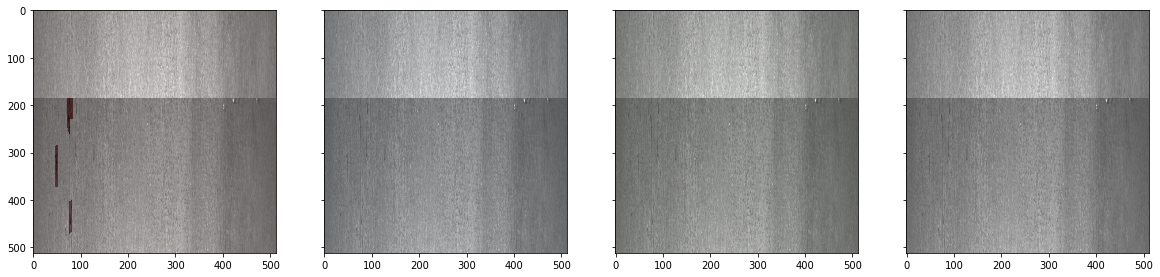

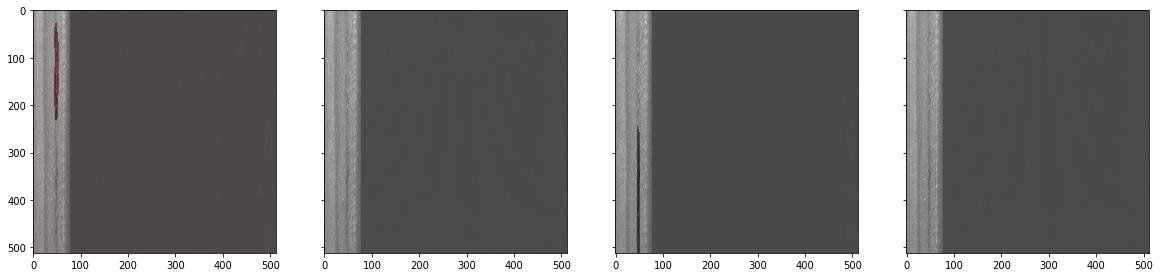

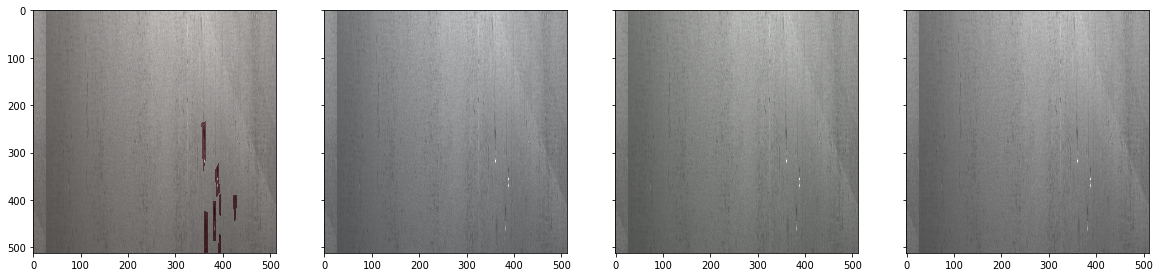

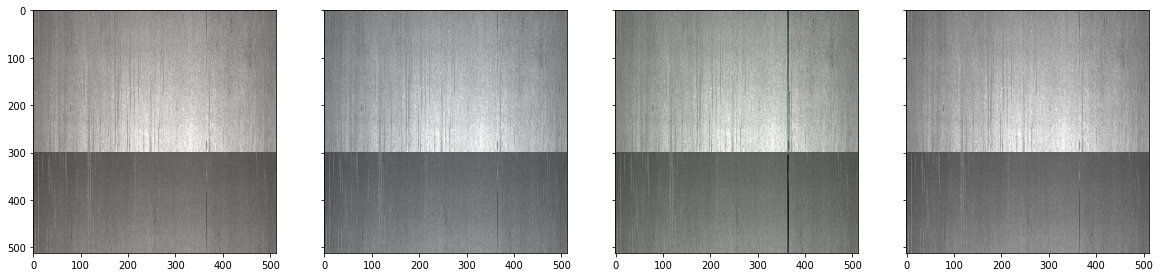

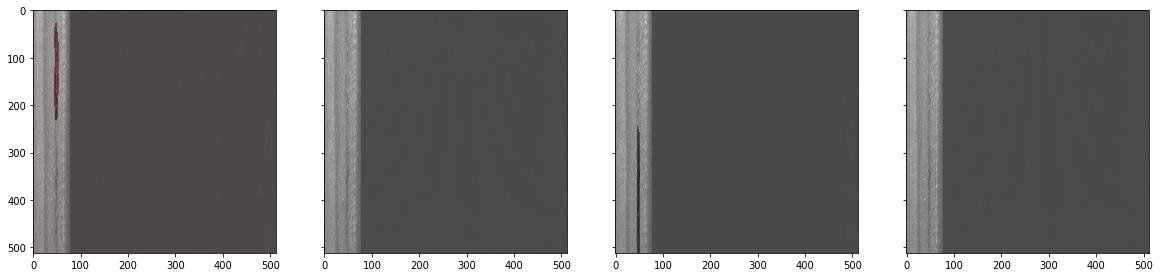

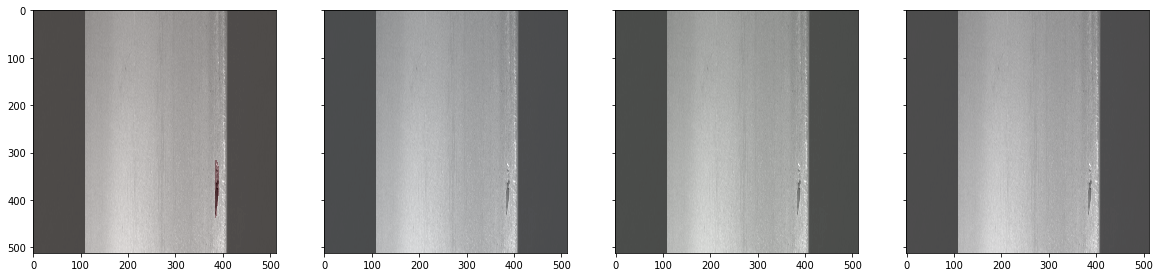

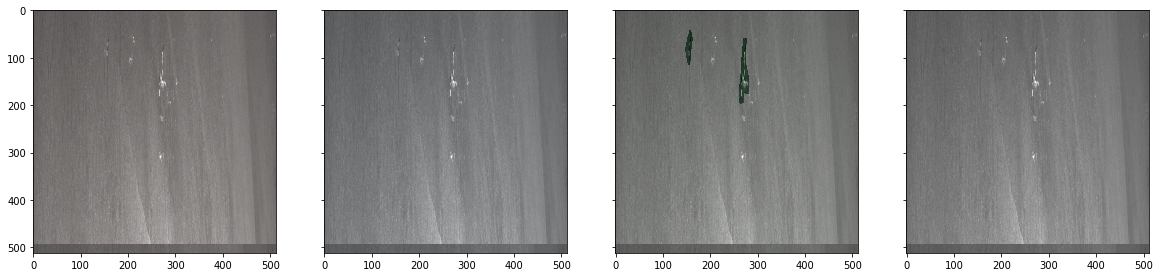

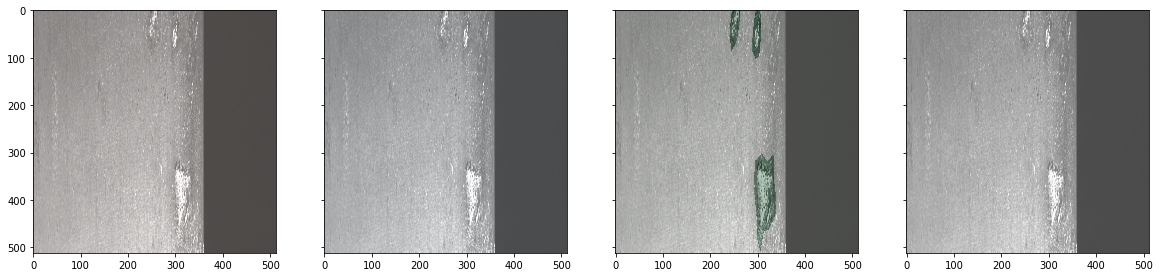

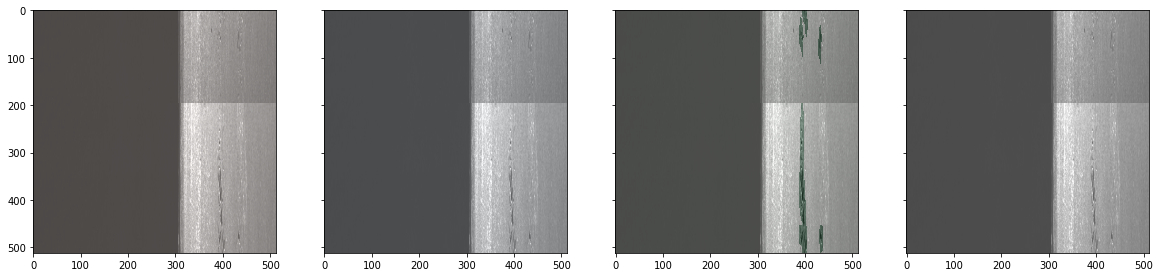

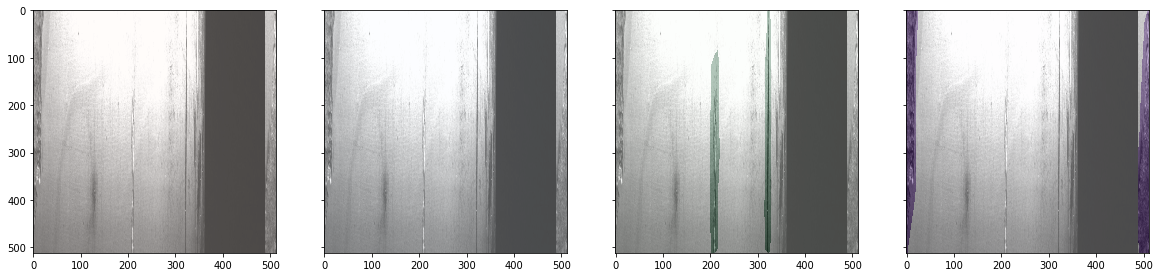

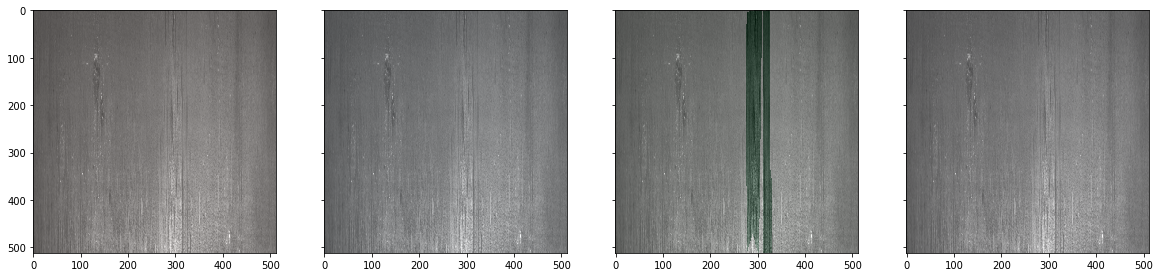

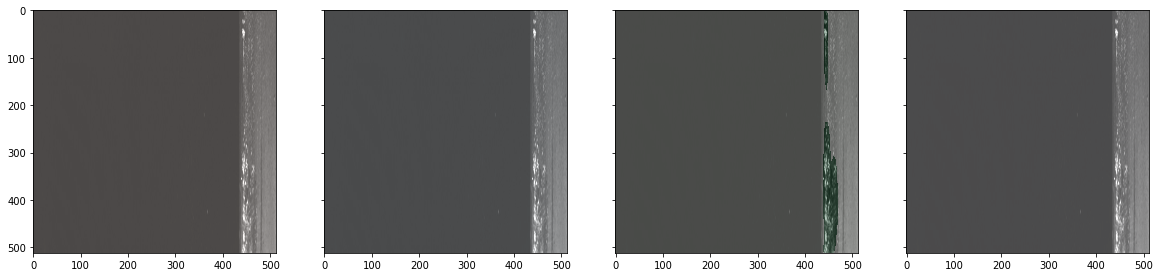

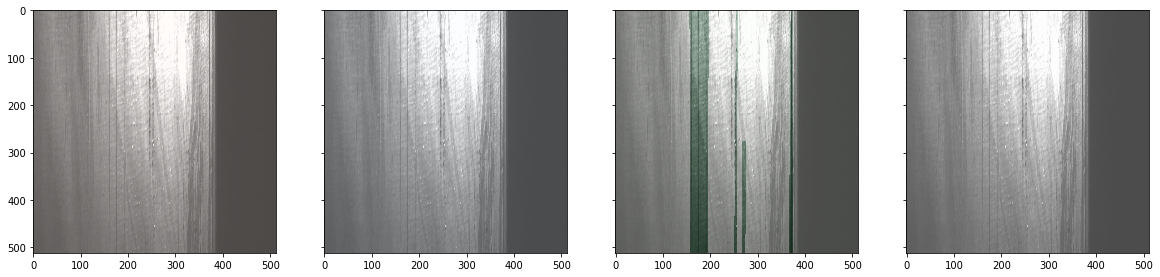

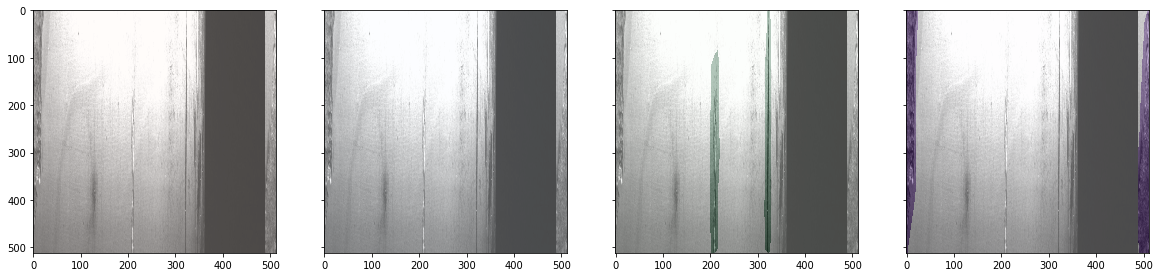

In [264]:
# lets visualize some images with their faults to see examples for each error type (resp. 3 images per error type)
# these examples suggest that errors of type 1 (masked in the left row) are barely visible to the eye
for k in range(3):
    x,y = training_generator.__getitem__(k) 
    for err in range(4):
        count = 0
        for ix in range(0,batch_size):
            if y[ix,:,:,err].sum() > 0:
                img = x[ix]
                img = (img - img.min())/(img.max()-img.min())
                masks_temp = [y[ix][...,i] for i in range(0,4)]
                viz_steel_img_mask(img, masks_temp)
                if count>3:
                    break
                count+=1

## Resunet

In this section we will define the building blocks for our network and train our network.

In [31]:
config = {'img_h': img_h,'img_w': img_w,'img_c':1,'class_num':4}

def build_model():
    def ResBlock(input,filter,kernel_size,dilation_rates,stride):
        def branch(dilation_rate):
            x=tf.keras.layers.BatchNormalization()(input)
            x=tf.keras.layers.Activation('relu')(x)
            x=tf.keras.layers.Conv2D(filter,kernel_size,strides=stride,dilation_rate=dilation_rate,padding='same')(x)
            x=tf.keras.layers.BatchNormalization()(x)
            x=tf.keras.layers.Activation('relu')(x)
            x=tf.keras.layers.Conv2D(filter,kernel_size,strides=stride,dilation_rate=dilation_rate,padding='same')(x)
            return x
        out=[]
        for d in dilation_rates:
            out.append(branch(d))
        if len(dilation_rates)>1:
            out=tf.keras.layers.Add()(out)
        else:
            out=out[0]
        return out
    def PSPPooling(input,filter):
        x1=tf.keras.layers.MaxPooling2D(pool_size=(2,2))(input)
        x2=tf.keras.layers.MaxPooling2D(pool_size=(4,4))(input)
        x3=tf.keras.layers.MaxPooling2D(pool_size=(8,8))(input)
        x4=tf.keras.layers.MaxPooling2D(pool_size=(16,16))(input)
        x1=tf.keras.layers.Conv2D(int(filter/4),(1,1))(x1)
        x2=tf.keras.layers.Conv2D(int(filter/4),(1,1))(x2)
        x3=tf.keras.layers.Conv2D(int(filter/4),(1,1))(x3)
        x4=tf.keras.layers.Conv2D(int(filter/4),(1,1))(x4)
        x1=tf.keras.layers.UpSampling2D(size=(2,2))(x1)
        x2=tf.keras.layers.UpSampling2D(size=(4,4))(x2)
        x3=tf.keras.layers.UpSampling2D(size=(8,8))(x3)
        x4=tf.keras.layers.UpSampling2D(size=(16,16))(x4)
        x=tf.keras.layers.Concatenate()([x1,x2,x3,x4,input])
        x=tf.keras.layers.Conv2D(filter,(1,1))(x)
        return x

    def combine(input1,input2,filter):
        x=tf.keras.layers.Activation('relu')(input1)
        x=tf.keras.layers.Concatenate()([x,input2])
        x=tf.keras.layers.Conv2D(filter,(1,1))(x)
        return x
    inputs=tf.keras.layers.Input(shape=(config['img_h'], config['img_w'], config['img_c']))
    c1=x=tf.keras.layers.Conv2D(32,(1,1),strides=(1,1),dilation_rate=1)(inputs)
    c2=x=ResBlock(x,32,(3,3),[1,3,15,31],(1,1))
    x=tf.keras.layers.Conv2D(64,(1,1),strides=(2,2))(x)
    c3=x=ResBlock(x,64,(3,3),[1,3,15,31],(1,1))
    x=tf.keras.layers.Conv2D(128,(1,1),strides=(2,2))(x)
    c4=x=ResBlock(x,128,(3,3),[1,3,15],(1,1))
    x=tf.keras.layers.Conv2D(256,(1,1),strides=(2,2))(x)
    c5=x=ResBlock(x,256,(3,3),[1,3,15],(1,1))
    x=tf.keras.layers.Conv2D(512,(1,1),strides=(2,2))(x)
    x=ResBlock(x,512,(3,3),[1],(1,1))
    x=PSPPooling(x,512)
    x=tf.keras.layers.Conv2D(256,(1,1))(x)
    x=tf.keras.layers.UpSampling2D()(x)
    x=combine(x,c5,256)
    x=ResBlock(x,256,(3,3),[1,3,15],1)
    x=tf.keras.layers.Conv2D(128,(1,1))(x)
    x=tf.keras.layers.UpSampling2D()(x)
    x=combine(x,c4,128)
    x=ResBlock(x,128,(3,3),[1,3,15],1)
    x=tf.keras.layers.Conv2D(64,(1,1))(x)
    x=tf.keras.layers.UpSampling2D()(x)
    x=combine(x,c3,64)
    x=ResBlock(x,64,(3,3),[1,3,15,31],1)
    x=tf.keras.layers.Conv2D(32,(1,1))(x)
    x=tf.keras.layers.UpSampling2D()(x)
    x=combine(x,c2,32)
    x=ResBlock(x,32,(3,3),[1,3,15,31],1)
    x=combine(x,c1,32)
    x=PSPPooling(x,32)
    x=tf.keras.layers.Conv2D(config['class_num'],(1,1))(x)
    x=tf.keras.layers.Activation('sigmoid')(x)
    model=tf.keras.Model(inputs=inputs,outputs=x)
    model.summary()
    return model
    
    
model = build_model()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_83 (Conv2D)              (None, 256, 256, 32) 64          input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_58 (BatchNo (None, 256, 256, 32) 128         conv2d_83[0][0]                  
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 256, 256, 32) 128         conv2d_83[0][0]                  
____________________________________________________________________________________________

## Loss Functions

In [29]:
# Dice similarity coefficient loss from: https://github.com/nabsabraham/focal-tversky-unet
def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection = reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (reduce_sum(y_true_f) + reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [34]:
# Focal Tversky loss from:  https://github.com/nabsabraham/focal-tversky-unet
def tversky(y_true, y_pred, smooth=1e-6):
    y_true_pos = tf.keras.layers.Flatten()(y_true)
    y_pred_pos = tf.keras.layers.Flatten()(y_pred)
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky_loss(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return tf.keras.backend.pow((1-pt_1), gamma)

## Compile & Fit The Model

In [35]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model.compile(optimizer=adam, loss=focal_tversky_loss, metrics=[tversky])

In [33]:
if load_model:
    try:
        model.load_weights(model_path)
        print('pre-trained model loaded!')
    except OSError:
        print('You need to run the model and load the trained model')

pre-trained model loaded!


In [ ]:
path = 'model_check.h5'
call_b = [tf.keras.callbacks.ModelCheckpoint(
          filepath=path, monitor='val_loss', save_best_only=True,
          save_weights_only=False, mode='auto', save_freq='epoch')]

In [90]:
history = model.fit(x=training_generator, validation_data=validation_generator, epochs=epochs, verbose=1,callbacks=call_b)

In [ ]:
if save_model: 
    model.save(model_save_path)

## Inference

In [36]:
# list all data in history
if 0:
    print(history.history.keys())
    # summarize history for accuracy
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['tversky'])
    plt.plot(history.history['val_tversky'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

In [37]:
# a function to plot image with mask and image with predicted mask next to each other
def viz_single_fault(img, mask, pred, image_class):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,5))
    
    cmaps = ["Reds", "Blues", "Greens", "Purples"]
    
    ax[0].imshow(img)
    ax[0].imshow(mask, alpha=0.3, cmap=cmaps[image_class-1])
    ax[0].set_title('Mask - Defect Class %s' % image_class)
    
    ax[1].imshow(img)
    ax[1].imshow(pred, alpha=0.3, cmap=cmaps[image_class-1])
    ax[1].set_title('Predicted Mask - Defect Class %s' % image_class)
    
    plt.show()

In [38]:
# https://www.jeremyjordan.me/evaluating-image-segmentation-models/
def calculate_iou(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    if np.sum(union) == 0:
        iou_score = 0
    else:
        iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

____________________


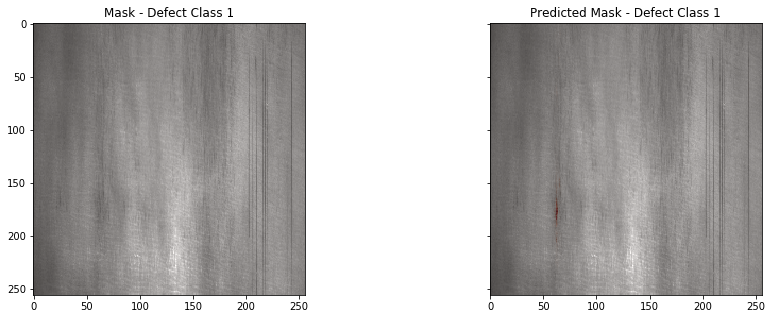

____________________


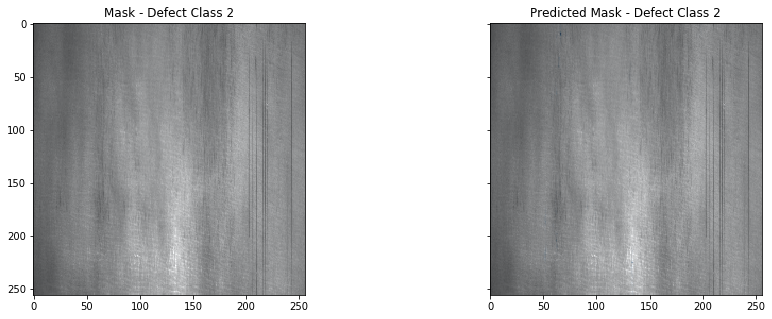

____________________


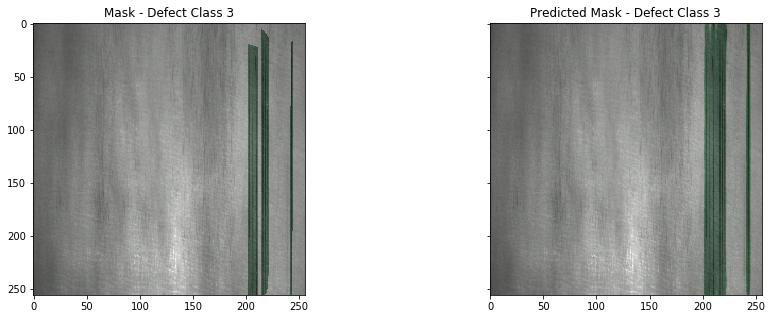

____________________


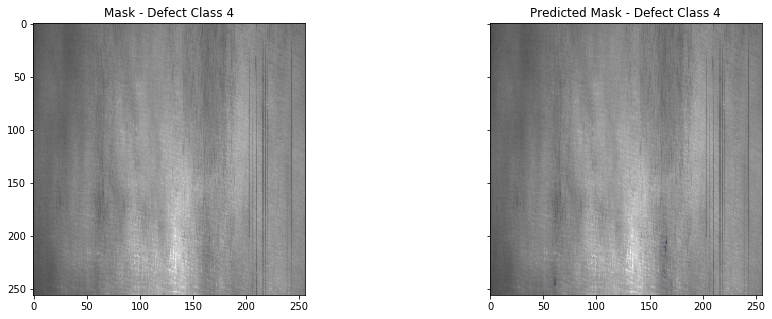

____________________


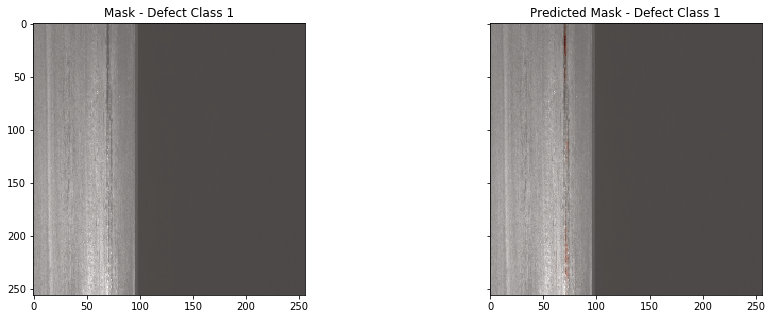

____________________


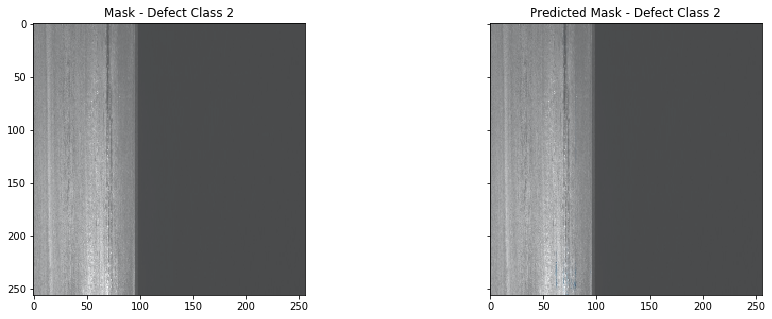

____________________


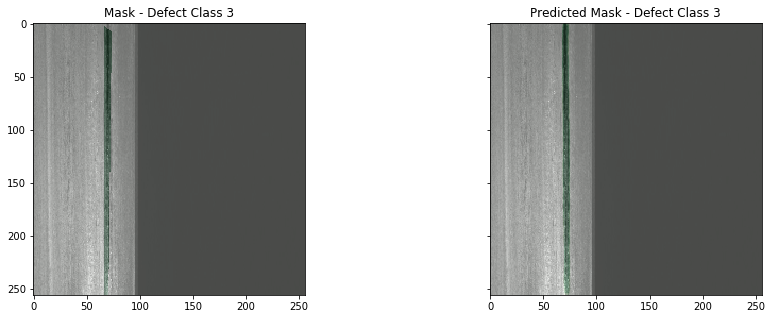

____________________


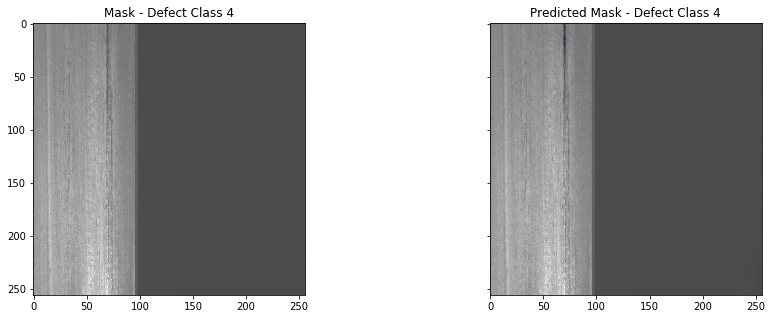

____________________


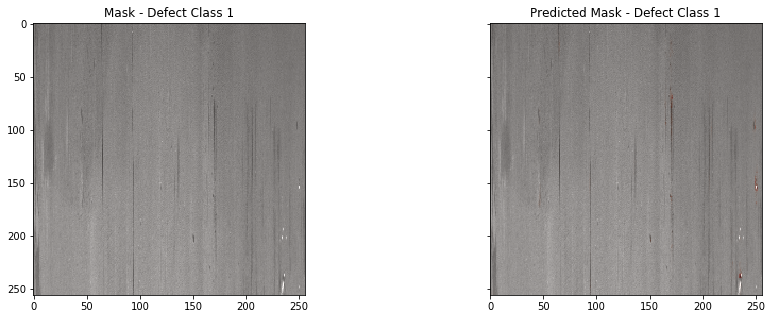

____________________


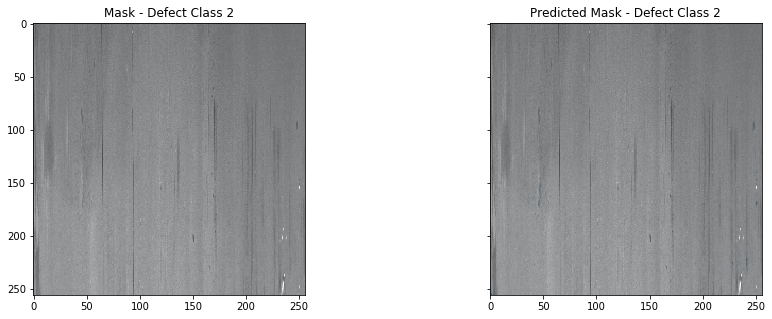

____________________


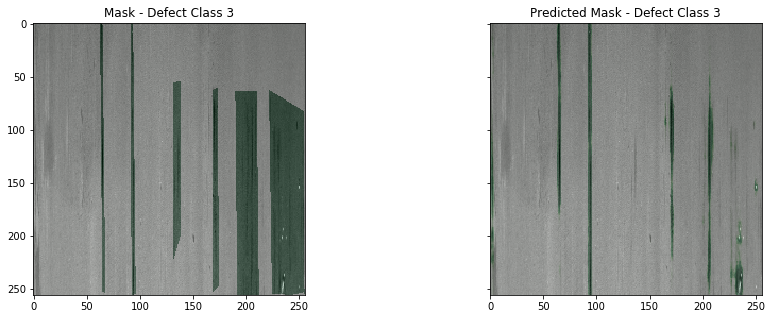

____________________


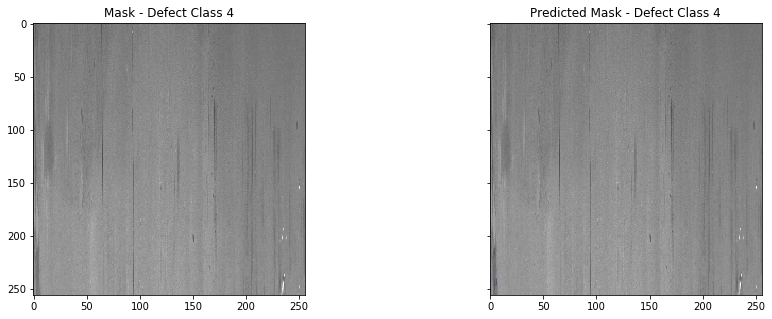

____________________


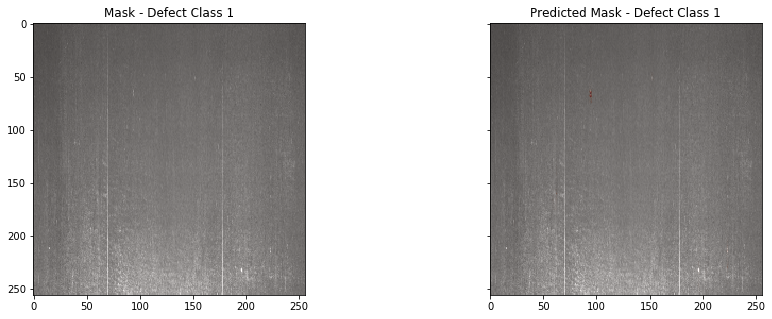

____________________


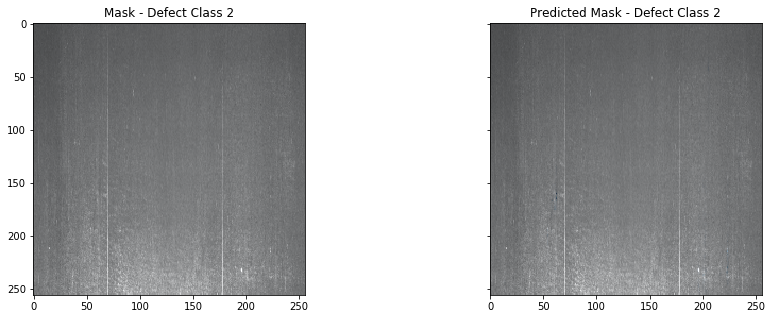

____________________


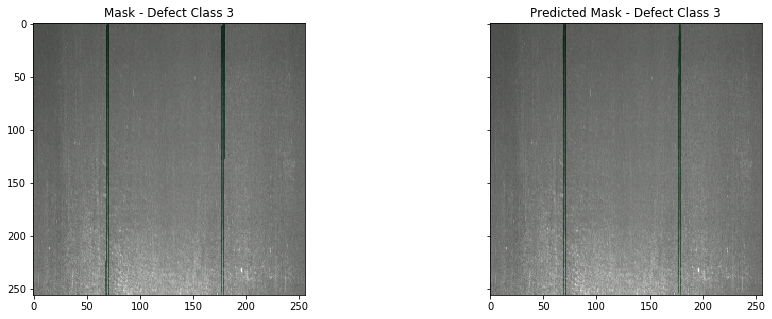

____________________


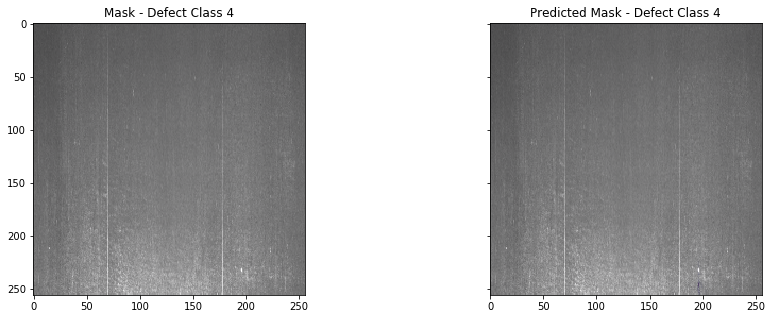

____________________


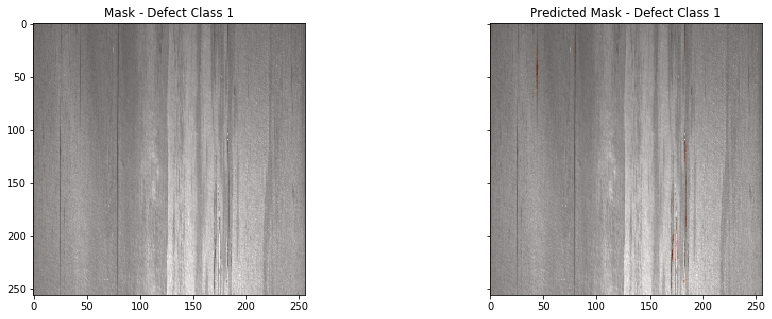

____________________


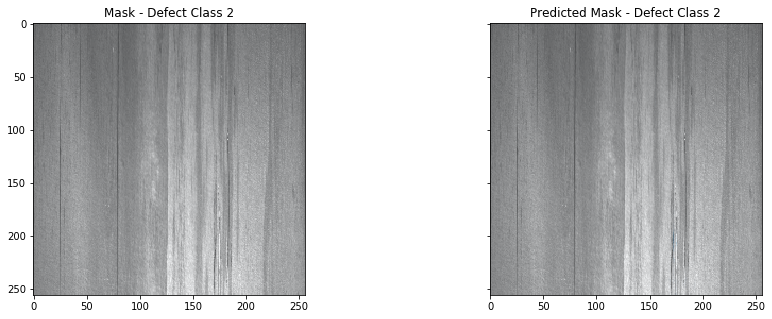

____________________


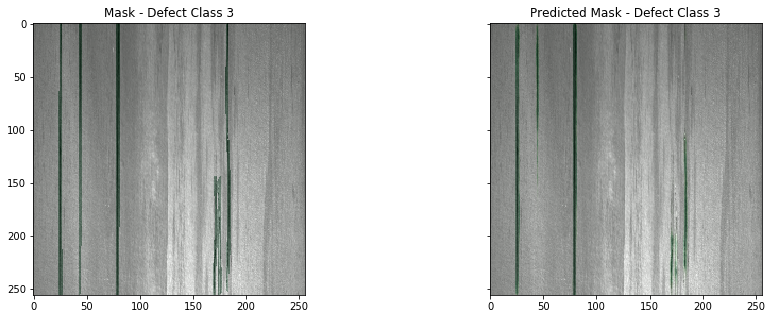

____________________


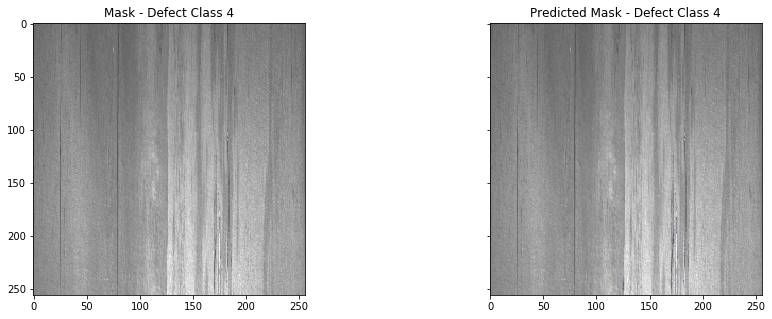

____________________


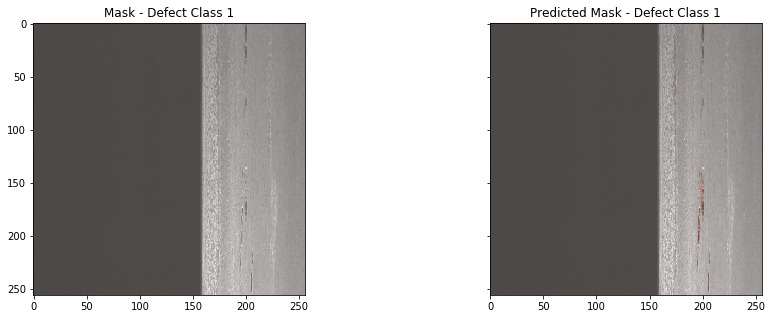

____________________


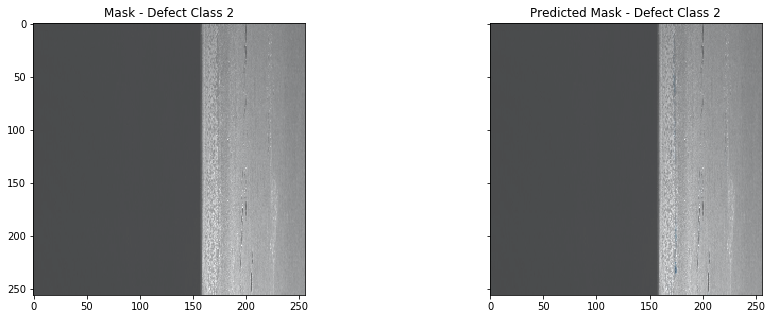

____________________


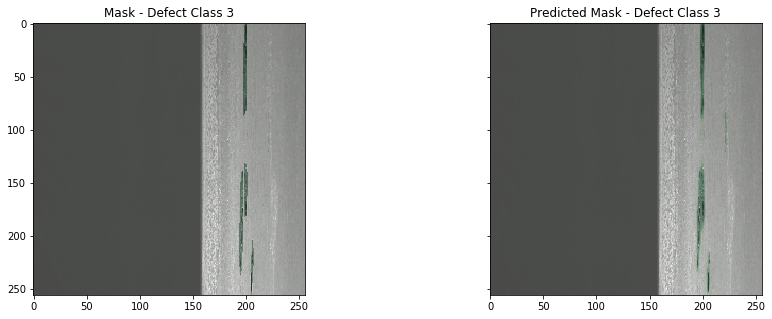

____________________


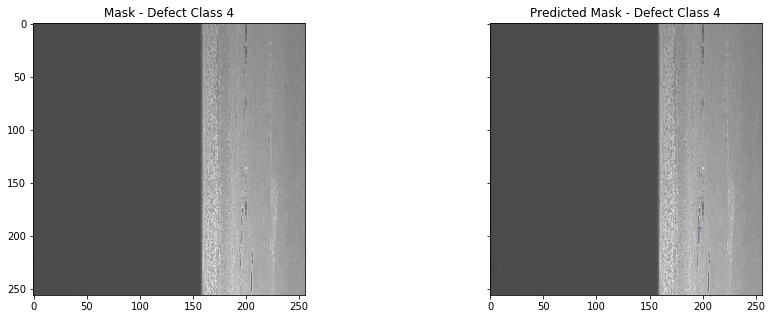

In [57]:

def plot_pred_vs_truth(num_samples=6,binary=False):
    """Plots 'num_samples' images of steel sheets with ground truth vs. predicted masks. """
    samples = np.random.randint(0,len(validation_generator),num_samples)
    # loop over to all the batches in one epoch 
    for i in samples:
    # get a batch of image, true mask, and predicted mask
        x, y = validation_generator.__getitem__(i)
        ind = np.random.randint(len(x))
        x,y = x[ind:ind+1],y[ind]
        predictions = model.predict_on_batch(x).numpy().squeeze()

        # we are only interested if there is a fault.
        if y.sum() > 0: 
            # get an image and convert to make it matplotlib.pyplot friendly
            
            img = x.astype('float32').squeeze()
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = (img-img.min())/(img.max()-img.min())
            # loop over the four ourput layers to create a list of all the masks for this image
            masks_temp = [y[...,i] for i in range(0,4)]
            # loop over the four output layers to create a list of all the predictions for this image
            preds_temp = [predictions[...,i] for i in range(0,4)]
            # turn to binary (prediction) mask 
            if binary:
                preds_temp = [p > .5 for p in preds_temp]

            for i, (mask, pred) in enumerate(zip(masks_temp, preds_temp)):
                image_class = i + 1
                #iou_score = calculate_iou(mask, pred)
                print("_"*20)
                #print('The IOU score is:', iou_score)

                viz_single_fault(img, mask, pred, image_class)
                
plot_pred_vs_truth()